# Machine Learning avancé : Deep Learning for NLP
On va mettre au point nos premiers modèles Deep Learning appliqué au traitement du langage. Plutôt que de tout recoder de zéro, on va ici s'appuyer sur la puissance de la librairie Keras qui nous permettra de connecter les layers à la volée et d'implémenter des architectures plus exotiques.

Après cela vous saurez:
- utiliser un embedding pré-calculé
- construire un réseau de neurones avec Keras
- construire une architecture custom avec Keras

Cet exercice constitue également le test noté du cours

## Import des Librairies

In [1]:
import data_utils.utils as du
import data_utils.pos as pos 
import numpy as np
import pandas
data='data/'
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, Masking
from keras.optimizers import RMSprop
from keras import backend as K
from keras import activations

## Présentation du problème
Le POS-Tagging et le Shallow Parsing constituent deux tâches classiques en NLP :
- POS-Tagging : affecte à chaque mot un tag unique qui indique son rôle syntaxique (nom, verbe, adverbe, ..)
- Shallow Parsing : affecte à chaque segment de phrase un tag unique qui indique le rôle de l'élément syntaxique auquel il appartient (groupe nominal, groupe verbal, etc..)
Les fichiers sont ici au format ConLL : un mot par ligne, les phrases sont séparées par un saut de ligne.

Nous allons ici refaire les travaux de l'article NLP almost from scratch, qui consiste à créer un réseau de neurones pour effectuer chaque tâche, puis nous ferons un modèle partagé et enfin un modèle hiearchique.

<img src="MLP.png" style="width:300px;height:450px;">
<caption><center> <u>Figure 1</u>: Modèle simple pour les tâches POS-Tagging et Shallow Parsing</center></caption>

# POS-Tagging
## Import des données

A l'aide des fonctions d'aide, importer les données :

#### Word embedding

In [20]:
wv, word_to_num, num_to_word = pos.load_wv(
      data+'vocab.txt', data+'wordVectors.txt')
print('wordvector shape is',wv.shape)

wordvector shape is (100003, 50)


On récupère également les tags et on crée les dictionnaires adéquats

#### Création des tags

In [21]:
tagnames = ['ADJ','ADJWH','ADV','ADVWH','CC','CLO',
                'CLR','CLS','CS','DET','DETWH','ET','I','NC',
                'NPP','P','P+D','P+PRO','PONCT','PREF','PRO',
                'PROREL','PROWH','VINF','VPR','VPP','V','VS','VIMP']
num_to_tag = dict(enumerate(tagnames))
tag_to_num = {v:k for k,v in num_to_tag.items()}

#### Chargement des données text

Chargement des documents puis création des matrices X_train, y_train, X_test, y_test
le paramètre wsize précise la taille de la fenêtre, choisissez une valeur par défaut parmis (3,5,7)

In [22]:
docs_train = du.load_dataset(data+'train.txt') # liste qui contient les phrases et les tags
X_train, y_train = du.docs_to_windows(docs_train, word_to_num, tag_to_num, wsize=3) # parcourt la liste et créer les matrices 

In [5]:
docs_train[0]

[['paul', 'NC'],
 ['jules', 'ADJ'],
 ['antoine', 'NC'],
 ['meillet', 'ADJ'],
 [',', 'PONCT'],
 ['nÃ©', 'VPP'],
 ['le', 'DET'],
 ['Ã\xa0', 'P'],
 ['moulins', 'NC'],
 ['(', 'PONCT'],
 ['allier', 'NC'],
 [')', 'PONCT'],
 ['et', 'CC'],
 ['mort', 'ADV'],
 ['le', '_ADV'],
 ['Ã\xa0', '_ADV'],
 ['chÃ¢teaumeillant', '_ADV'],
 ['(', 'PONCT'],
 ['cher', 'ADJ'],
 [')', 'PONCT'],
 [',', 'PONCT'],
 ['est', 'V'],
 ['le', 'DET'],
 ['principal', 'ADJ'],
 ['linguiste', 'NC'],
 ['franÃ§ais', 'ADJ'],
 ['des', 'P+D'],
 ['premiÃ¨res', 'ADJ'],
 ['dÃ©cennies', 'NC'],
 ['du', 'P+D'],
 ['.', 'PONCT']]

In [23]:
docs_test = du.load_dataset(data+'test.txt')
X_test, y_test = du.docs_to_windows(
    docs_test, word_to_num, tag_to_num, wsize=3)

In [24]:
y_train = keras.utils.to_categorical(y_train, 29)
y_test = keras.utils.to_categorical(y_test, 29)

On extrait les lignes dans y_test qui contiennent des mots non-présents dans X_train : out of vocabulary.

In [25]:
X_test_oov,Y_test_oov = du.get_oov(X_train,y_train,X_test,y_test)

In [9]:
print("X_train a pour dimension",X_train.shape)
print("X_test a pour dimension",X_test.shape)
print("y_train a pour dimension",y_train.shape)
print("y_test a pour dimension",y_test.shape)

X_train a pour dimension (680238, 3)
X_test a pour dimension (267334, 3)
y_train a pour dimension (680238, 29)
y_test a pour dimension (267334, 29)


In [10]:
print(np.amax(X_test))
print(np.amax(X_train))

38307
33062


### Question :

Expliquer ce que contient X et Y ci-dessus ainsi que leur dimension. (NB: Lorsque l'on définit une fenêtre on est amené à créer un tag pour le début et la fin de phrase afin que les premiers et derniers mots puissent être considérés dans le modèle

In [43]:
print(X_train[0])
print(y_train [0])

[0 0 0 1 2 3 4]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Réponse : X contient nos mots de vocabulaire encodés en chiffres pour qu'on puisse les utiliser dans le réseau de neurones. Y contient des informations à quelle classe appartient le mot renseigné dans le X. Notamment nous avons 29 classes, dans Y pour chaque élément il y a 28 fois 0 (donc le mot n'appartient pas à ces classes) et 1 fois 1 dans le cas d'appartenance à la classe.

## Création du NN

### Consigne :
Compléter le code ci-dessous pour définir une architecture :
Embed (dim 50) -> Dense -> Dropout -> Predict (Softmax).
N'hésitez pas à consulter l'aide de Keras pour :
    - models.Sequential
    - layers.Embedding
    - layers.Flatten
NB : Prendre garde à bien laisser l'embedding "entrainable" afin que la représentation vectorielle bénéficie aussi de la backprop

In [11]:
model = Sequential()
# Your code Here#
model.add(Embedding(38308,50,input_length=3,trainable=True))

model.add(Flatten())
model.add(Dense(29,input_dim=680238, activation=activations.relu))
model.add(Dropout(0.15))
model.add(Dense(29,activation=activations.softmax))



## Entrainement

### Questions :
- A quoi servent les layers suivants :
    - Flatten()
    - Dropout()
- Combien de paramètres seront appris au cours de l'entrainement? (il existe une commande qui permette de trouver l'architecture du réseau de neurones)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 50)             1915400   
_________________________________________________________________
flatten (Flatten)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 29)                4379      
_________________________________________________________________
dropout (Dropout)            (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                870       
Total params: 1,920,649
Trainable params: 1,920,649
Non-trainable params: 0
_________________________________________________________________


# Réponse : 
## Pourquoi flatten?

### Flatten layer permet d’aplatir l’input. Il fait un reshape de tensor de tel sort que nous obtenons à la sortie de la couche une forme égale à nombre d’éléments de tensor à l’input. Il n’inclut pas le batch size.  Par ex, le shape d’input (batch size, 5,5) après le flatten va avoir la forme (batch size, 25).

## Pourquoi dropout?

### Le Dropout est une méthode de régularisation. Au cours d’entrainement, certains sorties de couches sont ignorées ou «dropped out» au hasard. Cela permet de limiter overfitting.  Pour déterminer la fréquence de drop out il faut déterminer un paramètre dans cette couche qui est le rate (le taux de possibilité d’annuler la sortie de paramètre de la couche). Le plus souvent le dropout est utilisé entre 2 couches cachés.

## Le nombre de paramètres à apprendre?

### Au cours d'entrainement seront appris 1 920 649 paramètres. Nous pouvons voir cette chiffre en utilisant la commande model.summary() qui affiche le descriptif du modèle déterminé. Tous les paramètres sont entrainables.

### Consigne : Compilation
Compléter le code ci-dessous en choisissant l'optimizer RMSprop, et en choissisant la bonne loss (NB on est sur un probléme de classification à 29 modalités). La métrique sera renvoyée par les logs au cours de l'entrainement.

### Réponse:
### Nous avons une multi class classification avec un nombre de classes supérieur à 2. La fonction de loss la plus adaptée dans ce cas est categorical_crossentropy.

In [12]:
model.compile(loss ='categorical_crossentropy' ,
              optimizer = "RMSprop",
              metrics=['accuracy'])

### Consigne  : Entrainement
Compléter le code ci-dessous pour entrainer sur le couple X_train, Y_train et en validant sur X_test, Y_test. Vous devriez pouvoir atteindre une accuracy de 93% au bout de 3 itérations. N'oubliez pas que la taille du batch correspond au nombre d'exemples utilisés pour estimer le gradient. Il peut influer sur la convergence.

### NB
### Ici les résultats de la prémière modèle obtenu avec w_size = 3. Les résultats de la modèle ou j'ai pu atteindre 93% sur la 3ème itération sont présentés après dans la séction "Increase batch_size avec w_size 7"

In [14]:
history = model.fit(X_train,y_train,batch_size=29, epochs=3,validation_data=(X_test,y_test))


Epoch 1/3
23457/23457 [==============================] - 451s 19ms/step - loss: 0.6958 - accuracy: 0.8106 - val_loss: 0.4251 - val_accuracy: 0.8856
Epoch 2/3
23457/23457 [==============================] - 463s 20ms/step - loss: 0.4374 - accuracy: 0.8845 - val_loss: 0.4441 - val_accuracy: 0.8856
Epoch 3/3
23457/23457 [==============================] - 466s 20ms/step - loss: 0.4589 - accuracy: 0.8838 - val_loss: 0.4927 - val_accuracy: 0.8838


### Question :
- Nous avons décidé de regarder l'accuracy comme métrique. Expliquez en quoi ce choix est discutable.
- On se propose de tester la performance sur des données qui contiennent des mots non-vus lors du train dans la cellule ci-dessous lancer l'évaluation sur X_test_oov,Y_test_oov

# Réponse : 
### L'accuracy est un binaire vrai / faux. Elle se comporte comme une variable discrète. Si on prédit la classe 1 avec une probabilité 0.6 ou 0.9, pour accuracy il n'y a pas de différence dans ce cas et la réponse est vrais, c'est la classe 1 et donc accuracy va être la même dans les 2 cas. Pour cette raison cette métrique est discutable. Elle évolue les 2 situations comme un comportement équivalent. Il est donc nécessaire de décider si nous avons besoin de savoir seulement si la classe a été bien prédit ou il est important pour nous de savoir si la prédiction a été vraiment proche à notre classe ou non. Contrairement à l'accuracy on peut utiliser les fonctions de perte qui se comportent comme des variables discrètes et donc le cas de probabilité 0.9 est moins pénalisé que le cas de probabilité 0.6 dans le cas où nous avons besoin d'évoluer à quel point notre modèle a été proche à la classe réelle.


   ### Réponse : L'accuracy sur le X_test_oov et Y_test_oov est donc 81.83% 

In [26]:
model.evaluate(X_test_oov,Y_test_oov)

589/589 [==============================] - 1s 1ms/step - loss: 0.6338 - accuracy: 0.8183


[0.6338031888008118, 0.8183218240737915]

## Consigne :
- Déterminer quelle est la meilleur taille de fenêtre selon vous (tester les plusieurs hypothèses parmis 3, 5 et 7)
- Reprendre le code pour les différentes hypothèses suivantes avec la taille de fenêtre choisie ci-dessus :
    - 1 embedding random non entrainable
    - 2 embedding pré-entrainer (wv) entrainable
    - 3 embedding pré-entrainer (wv) non entrainable
- Conclure en testant sur X_test_oov et Y_test_oov :
    - Quelle est la méthode que vous choisiriez et pourquoi? 
    - Pouvez-vous expliquer intuitivement les différents résultats ? 

# w_size 5

In [4]:
docs_train = du.load_dataset(data+'train.txt') # liste qui contient les phrases et les tags
X_train, y_train = du.docs_to_windows(docs_train, word_to_num, tag_to_num, wsize=5) # parcourt la liste et créer les matrices 

docs_test = du.load_dataset(data+'test.txt')
X_test, y_test = du.docs_to_windows(
    docs_test, word_to_num, tag_to_num, wsize=5)

y_train = keras.utils.to_categorical(y_train, 29)
y_test = keras.utils.to_categorical(y_test, 29)

X_test_oov,Y_test_oov = du.get_oov(X_train,y_train,X_test,y_test)

In [5]:
print("X_train a pour dimension",X_train.shape)
print("X_test a pour dimension",X_test.shape)
print("y_train a pour dimension",y_train.shape)
print("y_test a pour dimension",y_test.shape)

X_train a pour dimension (680238, 5)
X_test a pour dimension (267334, 5)
y_train a pour dimension (680238, 29)
y_test a pour dimension (267334, 29)


In [6]:
model = Sequential()
# Your code Here#
model.add(Embedding(38308,50,input_length=5,trainable=True))

model.add(Flatten())
model.add(Dense(29,input_dim=680238, activation=activations.relu))
model.add(Dropout(0.15))
model.add(Dense(29,activation=activations.softmax))

model.compile(loss ='categorical_crossentropy' ,
              optimizer = "RMSprop",
              metrics=['accuracy'])
history = model.fit(X_train,y_train,batch_size=29, epochs=3,validation_data=(X_test,y_test))

Epoch 1/3
23457/23457 [==============================] - 368s 16ms/step - loss: 0.6803 - accuracy: 0.8155 - val_loss: 0.3914 - val_accuracy: 0.8918
Epoch 2/3
23457/23457 [==============================] - 371s 16ms/step - loss: 0.4043 - accuracy: 0.8927 - val_loss: 0.4181 - val_accuracy: 0.8945
Epoch 3/3
23457/23457 [==============================] - 380s 16ms/step - loss: 0.4249 - accuracy: 0.8936 - val_loss: 0.4473 - val_accuracy: 0.8908


In [7]:
model.evaluate(X_test_oov,Y_test_oov)

897/897 [==============================] - 1s 791us/step - loss: 0.5556 - accuracy: 0.8613


[0.5556387305259705, 0.8612843751907349]

# w_size 7

In [27]:
docs_train = du.load_dataset(data+'train.txt') # liste qui contient les phrases et les tags
X_train, y_train = du.docs_to_windows(docs_train, word_to_num, tag_to_num, wsize=7) # parcourt la liste et créer les matrices 

docs_test = du.load_dataset(data+'test.txt')
X_test, y_test = du.docs_to_windows(
    docs_test, word_to_num, tag_to_num, wsize=7)

y_train = keras.utils.to_categorical(y_train, 29)
y_test = keras.utils.to_categorical(y_test, 29)

X_test_oov,Y_test_oov = du.get_oov(X_train,y_train,X_test,y_test)

In [9]:
print("X_train a pour dimension",X_train.shape)
print("X_test a pour dimension",X_test.shape)
print("y_train a pour dimension",y_train.shape)
print("y_test a pour dimension",y_test.shape)

X_train a pour dimension (680238, 7)
X_test a pour dimension (267334, 7)
y_train a pour dimension (680238, 29)
y_test a pour dimension (267334, 29)


In [10]:
model = Sequential()
# Your code Here#
model.add(Embedding(38308,50,input_length=7,trainable=True))

model.add(Flatten())
model.add(Dense(29,input_dim=680238, activation=activations.relu))
model.add(Dropout(0.15))
model.add(Dense(29,activation=activations.softmax))

model.compile(loss ='categorical_crossentropy' ,
              optimizer = "RMSprop",
              metrics=['accuracy'])
history = model.fit(X_train,y_train,batch_size=29, epochs=3,validation_data=(X_test,y_test))

Epoch 1/3
23457/23457 [==============================] - 376s 16ms/step - loss: 0.6712 - accuracy: 0.8156 - val_loss: 0.3892 - val_accuracy: 0.8937
Epoch 2/3
23457/23457 [==============================] - 370s 16ms/step - loss: 0.4019 - accuracy: 0.8922 - val_loss: 0.4200 - val_accuracy: 0.8947
Epoch 3/3
23457/23457 [==============================] - 373s 16ms/step - loss: 0.4181 - accuracy: 0.8936 - val_loss: 0.4488 - val_accuracy: 0.8913


In [11]:
model.evaluate(X_test_oov,Y_test_oov)

1159/1159 [==============================] - 2s 1ms/step - loss: 0.5254 - accuracy: 0.8711


[0.5254338383674622, 0.8710651993751526]

# Il est possible de sauvegarder le modèle (les poids W) dans un fichier .h5

In [13]:
model.save("my_model.h5")

#  Embedding non trainable

In [14]:
model = Sequential()
# Your code Here#
model.add(Embedding(38308,50,input_length=7,trainable=False))

model.add(Flatten())
model.add(Dense(29,input_dim=680238, activation=activations.relu))
model.add(Dropout(0.15))
model.add(Dense(29,activation=activations.softmax))

model.compile(loss ='categorical_crossentropy' ,
              optimizer = "RMSprop",
              metrics=['accuracy'])
history = model.fit(X_train,y_train,batch_size=29, epochs=3,validation_data=(X_test,y_test))

Epoch 1/3
23457/23457 [==============================] - 35s 1ms/step - loss: 1.3850 - accuracy: 0.6070 - val_loss: 0.8550 - val_accuracy: 0.7493
Epoch 2/3
23457/23457 [==============================] - 39s 2ms/step - loss: 0.8914 - accuracy: 0.7394 - val_loss: 0.7843 - val_accuracy: 0.7698
Epoch 3/3
23457/23457 [==============================] - 39s 2ms/step - loss: 0.8451 - accuracy: 0.7518 - val_loss: 0.7679 - val_accuracy: 0.7758


In [15]:
model.evaluate(X_test_oov,Y_test_oov)

1159/1159 [==============================] - 1s 810us/step - loss: 0.8521 - accuracy: 0.7615


[0.8521138429641724, 0.7615245580673218]

# Embedding pré-entrainer entrainable

In [20]:
vocabLen = len(word_to_num)
DimEmb=50


In [22]:
model = Sequential()
# Your code Here#
model.add(Input(shape=(7,), dtype='int32'))
model.add(Embedding(vocabLen, DimEmb, weights=[wv], trainable=True))

model.add(Flatten())
model.add(Dense(29,input_dim=680238, activation=activations.relu))
model.add(Dropout(0.15))
model.add(Dense(29,activation=activations.softmax))

model.compile(loss ='categorical_crossentropy' ,
              optimizer = "RMSprop",
              metrics=['accuracy'])
history = model.fit(X_train,y_train,batch_size=29, epochs=3,validation_data=(X_test,y_test))


Epoch 1/3
23457/23457 [==============================] - 932s 40ms/step - loss: 0.6117 - accuracy: 0.8300 - val_loss: 0.3809 - val_accuracy: 0.8961
Epoch 2/3
23457/23457 [==============================] - 924s 39ms/step - loss: 0.4138 - accuracy: 0.8895 - val_loss: 0.4146 - val_accuracy: 0.8965
Epoch 3/3
23457/23457 [==============================] - 932s 40ms/step - loss: 0.4328 - accuracy: 0.8893 - val_loss: 0.4427 - val_accuracy: 0.8919


In [23]:
model.evaluate(X_test_oov,Y_test_oov)

1159/1159 [==============================] - 1s 797us/step - loss: 0.5015 - accuracy: 0.8758


[0.5014654397964478, 0.8758125901222229]

# Embedding pré-entrainer non entrainable

In [29]:
model = Sequential()
# Your code Here#
model.add(Input(shape=(7,), dtype='int32'))
model.add(Embedding(vocabLen, DimEmb, weights=[wv], trainable=False))

model.add(Flatten())
model.add(Dense(29,input_dim=680238, activation=activations.relu))
model.add(Dropout(0.15))
model.add(Dense(29,activation=activations.softmax))

model.compile(loss ='categorical_crossentropy' ,
              optimizer = "RMSprop",
              metrics=['accuracy'])
history = model.fit(X_train,y_train,batch_size=29, epochs=3,validation_data=(X_test,y_test))


Epoch 1/3
23457/23457 [==============================] - 34s 1ms/step - loss: 0.7616 - accuracy: 0.7887 - val_loss: 0.4734 - val_accuracy: 0.8718
Epoch 2/3
23457/23457 [==============================] - 33s 1ms/step - loss: 0.5326 - accuracy: 0.8543 - val_loss: 0.4853 - val_accuracy: 0.8696
Epoch 3/3
23457/23457 [==============================] - 34s 1ms/step - loss: 0.5602 - accuracy: 0.8505 - val_loss: 0.5137 - val_accuracy: 0.8659


In [30]:
model.evaluate(X_test_oov,Y_test_oov)

1159/1159 [==============================] - 1s 832us/step - loss: 0.5904 - accuracy: 0.8515


[0.5904478430747986, 0.8514552116394043]

# Increase batch_size avec w_size 7

In [29]:
model = Sequential()
# Your code Here#
model.add(Embedding(38308,50,input_length=7,trainable=True))

model.add(Flatten())
model.add(Dense(128,input_dim=680238, activation=activations.relu))
model.add(Dropout(0.15))
model.add(Dense(29,activation=activations.softmax))

In [30]:
model.compile(loss ='categorical_crossentropy' ,
              optimizer = "RMSprop",
              metrics=['accuracy'])

In [32]:
history = model.fit(X_train,y_train,batch_size=128, epochs=7,validation_data=(X_test,y_test))

Epoch 1/7
5315/5315 [==============================] - 108s 20ms/step - loss: 0.3260 - accuracy: 0.9006 - val_loss: 0.2989 - val_accuracy: 0.9080
Epoch 2/7
5315/5315 [==============================] - 108s 20ms/step - loss: 0.2640 - accuracy: 0.9192 - val_loss: 0.2868 - val_accuracy: 0.9118
Epoch 3/7
5315/5315 [==============================] - 113s 21ms/step - loss: 0.2423 - accuracy: 0.9264 - val_loss: 0.2897 - val_accuracy: 0.9138
Epoch 4/7
5315/5315 [==============================] - 114s 22ms/step - loss: 0.2291 - accuracy: 0.9309 - val_loss: 0.2978 - val_accuracy: 0.9142
Epoch 5/7
5315/5315 [==============================] - 109s 20ms/step - loss: 0.2198 - accuracy: 0.9344 - val_loss: 0.3053 - val_accuracy: 0.9129
Epoch 6/7
5315/5315 [==============================] - 110s 21ms/step - loss: 0.2133 - accuracy: 0.9373 - val_loss: 0.3185 - val_accuracy: 0.9122
Epoch 7/7
5315/5315 [==============================] - 110s 21ms/step - loss: 0.2070 - accuracy: 0.9396 - val_loss: 0.3330 -

In [33]:
model.evaluate(X_test_oov,Y_test_oov, batch_size=128)

290/290 [==============================] - 0s 2ms/step - loss: 0.4314 - accuracy: 0.8861


[0.4313601851463318, 0.8860626220703125]

# Réponse:
### En régardant les résultats des modèles avec differents tailles de la fênetre J'ai constaté que la meilleure pérformance obtenu est celle avec la taille de la fenêtre maximale qui est le 7. 

### En regardant les tests avec le layer Embedding different, la meilleure méthode est celle avec Embedding entrainable sans pré-entrainement en terme d'accuracy. En terme de temps d'éxecution méthode avec Embedding pré-entrainé non trainable est meileur. Elle nécessite le moins de temps et en terme de performance accuracy est proche avec Embedding trainable sans pré-entrainement.

### Embedding pré-entrainé trainable donne des résultats equivalents à l'Embedding trainable sans pré-entrainement, mais en terme de temps d''éxecuton cette méthode à pris le plus de temps.

### Parmis ces méthodes il est envisageable d'utiliser la taille de  fênetre plus large avec Embedding entrainable(La méthode que je choissirais, parce que la qualité de prédiction est meilleur malgré le temps nécessair ). Ensuite, si il est nécessaire de concerver le temps et avoir une assez bon performance, il est possible utilisé Embedding pé-entrainé avec paramètre Trainable=False.

### Finallement, j'ai tenté d'augmenter le batch_size ce qui a pérmit de coberger plus vite et diminuer le temps d'entrainement. Au bout de la 3eme itération l'accuracy est près de 93% ce qui a été rechércé.

   ### Je pourrait supposer  que l'Embedding pré-entrainé n'est pas adapté pour notre modèle et ) notre tache. Pour cette raison la performance est moindre. Pour adapter Embedding pré entrainé a notre situation il faut mettre le paramètre trainable = True, mais dans ce cas le processus est long, parce que le vocabulaire est plus large par arpport à celui utilisé pour le Test/Train échantillons. Il est nécessaie de faire plus de calculs. Donc la méthode plus exacte et moins couteuse en terme de temps est celui qui nécessite un entrainement de Embedding layer sur la base de notre train/test.

# Shallow Parsing

## Consigne :
- Reprendre la méthodologie ci-dessus et entrainer un modèle de shallow parsing
- Les tags sont ['O','B-NP','I-NP','B-AP','I-AP','B-CONJ',
                'I-CONJ','B-AdP','I-AdP','B-VN','I-VN','B-PP','I-PP','B-UNKNOWN','I-UNKNOWN']
- Les fichiers sont train_chunk.txt et test_chunk.txt
- N'oubliez pas de recréer les tests out-of-vocabulary (X_test_oov et Y_test_oov)
- Conclure sur votre choix du meilleur modèle

#### Word Embedding

In [34]:
wv, word_to_num, num_to_word = pos.load_wv(
      data+'vocab.txt', data+'wordVectors.txt')
print('wordvector shape is',wv.shape)

wordvector shape is (100003, 50)


#### Création des tags

In [35]:
tagnames = ['O','B-NP','I-NP','B-AP','I-AP','B-CONJ',
                'I-CONJ','B-AdP','I-AdP','B-VN','I-VN','B-PP','I-PP','B-UNKNOWN','I-UNKNOWN']
num_to_tag = dict(enumerate(tagnames))
tag_to_num = {v:k for k,v in num_to_tag.items()}

#### Chargement des données

In [36]:
docs_train = du.load_dataset(data+'train_chunk.txt') # liste qui contient les phrases et les tags
X_train, y_train = du.docs_to_windows(docs_train, word_to_num, tag_to_num, wsize=7) # parcourt la liste et créer les matrices 


In [37]:
docs_test = du.load_dataset(data+'test_chunk.txt')
X_test, y_test = du.docs_to_windows(
    docs_test, word_to_num, tag_to_num, wsize=7)

In [38]:
y_train = keras.utils.to_categorical(y_train, 15)
y_test = keras.utils.to_categorical(y_test, 15)

In [39]:
X_test_oov,Y_test_oov = du.get_oov(X_train,y_train,X_test,y_test)

In [37]:
print("X_train a pour dimension",X_train.shape)
print("X_test a pour dimension",X_test.shape)
print("y_train a pour dimension",y_train.shape)
print("y_test a pour dimension",y_test.shape)

X_train a pour dimension (680238, 7)
X_test a pour dimension (267334, 7)
y_train a pour dimension (680238, 15)
y_test a pour dimension (267334, 15)


In [38]:
docs_train[0]

[['paul', 'B-NP'],
 ['jules', 'I-NP'],
 ['antoine', 'B-NP'],
 ['meillet', 'I-PP'],
 [',', 'O'],
 ['nÃ©', 'B-NP'],
 ['le', 'B-NP'],
 ['Ã\xa0', 'I-NP'],
 ['moulins', 'I-PP'],
 ['(', 'O'],
 ['allier', 'B-NP'],
 [')', 'O'],
 ['et', 'B-CONJ'],
 ['mort', 'B-VN'],
 ['le', 'B-NP'],
 ['Ã\xa0', 'I-PP'],
 ['chÃ¢teaumeillant', 'I-PP'],
 ['(', 'O'],
 ['cher', 'B-NP'],
 [')', 'O'],
 [',', 'O'],
 ['est', 'B-VN'],
 ['le', 'B-NP'],
 ['principal', 'I-NP'],
 ['linguiste', 'I-NP'],
 ['franÃ§ais', 'I-PP'],
 ['des', 'B-PP'],
 ['premiÃ¨res', 'I-PP'],
 ['dÃ©cennies', 'I-PP'],
 ['du', 'I-PP'],
 ['.', 'O']]

model.compile(loss ='categorical_crossentropy' ,
              optimizer = "RMSprop",
              metrics=['accuracy'])

In [39]:
print(np.amax(X_test))
print(np.amax(X_train))

38307
33062


#### Création du réseau de neurones

In [40]:
model = Sequential()
# Your code Here#
model.add(Embedding(38308,50,input_length=7,trainable=True))

model.add(Flatten())
model.add(Dense(15,input_dim=680238, activation=activations.relu))
model.add(Dropout(0.15))
model.add(Dense(15,activation=activations.softmax))

model.compile(loss ='categorical_crossentropy' ,
              optimizer = "RMSprop",
              metrics=['accuracy'])


#### Entrainement

In [41]:
history = model.fit(X_train,y_train,batch_size=15, epochs=3,validation_data=(X_test,y_test))

Epoch 1/3
45350/45350 [==============================] - 938s 21ms/step - loss: 0.7579 - accuracy: 0.7663 - val_loss: 0.5808 - val_accuracy: 0.8338
Epoch 2/3
45350/45350 [==============================] - 963s 21ms/step - loss: 0.6441 - accuracy: 0.8194 - val_loss: 0.6619 - val_accuracy: 0.8259
Epoch 3/3
45350/45350 [==============================] - 942s 21ms/step - loss: 0.7265 - accuracy: 0.8094 - val_loss: 0.7655 - val_accuracy: 0.8164


In [42]:
model.evaluate(X_test_oov,Y_test_oov)

1159/1159 [==============================] - 2s 1ms/step - loss: 0.6942 - accuracy: 0.8187


[0.6941934823989868, 0.8186550736427307]

#  Increase batch_size avec w_size 7

In [40]:
model = Sequential()
# Your code Here#
model.add(Embedding(38308,50,input_length=7,trainable=True))

model.add(Flatten())
model.add(Dense(128,input_dim=680238, activation=activations.relu))
model.add(Dropout(0.15))
model.add(Dense(15,activation=activations.softmax))
model.compile(loss ='categorical_crossentropy' ,
              optimizer = "RMSprop",
              metrics=['accuracy'])

In [41]:
history = model.fit(X_train,y_train,batch_size=128, epochs=7,validation_data=(X_test,y_test))

Epoch 1/7
5315/5315 [==============================] - 108s 20ms/step - loss: 0.6770 - accuracy: 0.7847 - val_loss: 0.3828 - val_accuracy: 0.8713
Epoch 2/7
5315/5315 [==============================] - 112s 21ms/step - loss: 0.3414 - accuracy: 0.8858 - val_loss: 0.3577 - val_accuracy: 0.8805
Epoch 3/7
5315/5315 [==============================] - 110s 21ms/step - loss: 0.3048 - accuracy: 0.8985 - val_loss: 0.3534 - val_accuracy: 0.8815
Epoch 4/7
5315/5315 [==============================] - 116s 22ms/step - loss: 0.2818 - accuracy: 0.9070 - val_loss: 0.3560 - val_accuracy: 0.8821
Epoch 5/7
5315/5315 [==============================] - 112s 21ms/step - loss: 0.2648 - accuracy: 0.9127 - val_loss: 0.3647 - val_accuracy: 0.8820
Epoch 6/7
5315/5315 [==============================] - 108s 20ms/step - loss: 0.2535 - accuracy: 0.9171 - val_loss: 0.3744 - val_accuracy: 0.8811
Epoch 7/7
5315/5315 [==============================] - 109s 20ms/step - loss: 0.2454 - accuracy: 0.9209 - val_loss: 0.3873 -

In [42]:
model.evaluate(X_test_oov,Y_test_oov)

1159/1159 [==============================] - 1s 1ms/step - loss: 0.3625 - accuracy: 0.8854


[0.36248621344566345, 0.8854422569274902]

#### Conclusion

### La pérformance  de Shallow Parsing est similaire à celui de POS tagging. Cependant dans les mêmes conditions et avec les mêmes paramètres sur le même nombre d'itérations l'accuracy est moindre pour le Shallow Parsing. Pour cette raison je choisirais la méthode de POS tagging.

### Si choisir parmi les différentes méthodes sur la base de Shallow parsing, le meilleur modèle est aussi avec un w_size=7 avec Embedding trainable sans les poids pré-entrainés et avec un batch size 128 avec une convergence plus vite.


# Multi-task learning

## Full multi tagged (POS tagging + Shallow parsing)

En deep learning, il est possible et parfois même recommandé d'entrainer un réseau de neurones sur plusieurs tâches en même temps. Intuitivement on se dit que l'apprentissage de représentation sur une tâche devrait pouvoir aider sur une autre tâche. Cela permet en outre de disposer de plus de données par exemple et/ou d'avoir un modèle plus robuste, plus précis.

Dans cette partie, on va s'appuyer sur la classe Model de Keras https://keras.io/getting-started/functional-api-guide/. Plutôt que d'ajouter les layers, il s'agit plutôt de voire chaque layer comme une fonction. Il s'agit alors d'enchainer les fonctions.

<img src="mtl_images.png" style="width:300px;height:450px;">
<caption><center> <u>Figure 1</u>: Un exemple d'architecture pour apprendre 3 tâches </center></caption>

#### Embedding

In [2]:
wv, word_to_num, num_to_word = pos.load_wv(
      data+'vocab.txt', data+'wordVectors.txt')
print('wordvector shape is',wv.shape)

wordvector shape is (100003, 50)


#### Création des tags

In [3]:
postagnames = ['ADJ','ADJWH','ADV','ADVWH','CC','CLO',
                'CLR','CLS','CS','DET','DETWH','ET','I','NC',
                'NPP','P','P+D','P+PRO','PONCT','PREF','PRO',
                'PROREL','PROWH','VINF','VPR','VPP','V','VS','VIMP']
num_to_postag = dict(enumerate(postagnames))
postag_to_num = {v:k for k,v in num_to_postag.items()}

In [4]:
chunktagnames = ['O','B-NP','I-NP','B-AP','I-AP','B-CONJ',
                'I-CONJ','B-AdP','I-AdP','B-VN','I-VN','B-PP','I-PP','B-UNKNOWN','I-UNKNOWN']
num_to_chunktag = dict(enumerate(chunktagnames))
chunktag_to_num = {v:k for k,v in num_to_chunktag.items()}

#### Import des données

In [5]:
# Load the training set
docs = du.load_dataset(data+'train.txt')
X_train, pos_train = du.docs_to_windows(
    docs, word_to_num, postag_to_num, wsize=5)
docs = du.load_dataset(data+'train_chunk.txt')
X_train, chunk_train = du.docs_to_windows(
    docs, word_to_num, chunktag_to_num, wsize=5)

In [6]:
docs = du.load_dataset(data+'test.txt')
X_test, pos_test = du.docs_to_windows(
    docs, word_to_num, postag_to_num, wsize=5)
docs = du.load_dataset(data+'test_chunk.txt')
X_test, chunk_test = du.docs_to_windows(
    docs, word_to_num, chunktag_to_num, wsize=5)

#### Mise en forme pour l'apprentissage

In [8]:
X_pos_train=X_train[:400000,:]

X_chunk_train=X_train[-400000:,]


In [9]:
Y_pos_train = keras.utils.to_categorical(pos_train[0:400000,], 29)
Y_pos_test = keras.utils.to_categorical(pos_test, 29)
Y_chunk_train = keras.utils.to_categorical(chunk_train[-400000:,], 15)
Y_chunk_test = keras.utils.to_categorical(chunk_test, 15)

In [10]:
print(X_pos_train.shape)
print(X_chunk_train.shape)
print(Y_pos_train.shape)
print(Y_chunk_train.shape)
print(Y_pos_test.shape)
print(Y_chunk_test.shape)

(400000, 5)
(400000, 5)
(400000, 29)
(400000, 15)
(267334, 29)
(267334, 15)


#### Résumé
Jusqu'à présent on dispose de :
- wv qui contient un embedding
- X_pos_ et Y_pos_ qui contiennent respectivement les mots et le tag sur train et test pour le pos tagging
- X_chunk_ et Y_chunk_ qui contiennent respectivement les mots et le tag sur train et test pour le shallow parsing
- X_pos et X_chunk n'ont aucune fenêtre en commun

### Création du réseaux de neurones commun aux deux tâches

#### Consigne
Utiliser la même architecture que précedemment pour construire le réseau de neurones communs : shared_nn

In [2]:
shared_nn=Sequential()
shared_nn.add(Embedding(38308,50,input_length=5,trainable=True))

shared_nn.add(Flatten())
shared_nn.add(Dense(128,input_dim=680238, activation=activations.relu))
shared_nn.add(Dropout(0.15))

#### Consigne
Définir les inputs du réseaux de neurones communs à l'aide de la fonction Input. Ce sont les input layer de notre architecture, chacun correspond à une tâche.

In [3]:
pos_input = Input(shape=(5,), dtype='int32', name='Pos')
chunk_input =Input(shape=(5,), dtype='int32',name='Chunk')

#### Consigne
- Définir pos_representation et chunk_representation comme les images respectibes de chaque input par shared_nn
- Définir pos_target et chunk_target comme l'image des représentations ci-dessus par des layers dense avec activation softmax (cf  la fonction Dense)

Rappel : la fonction softmax va calculer $n$ softmax, où $n$ est le nombre de classe en suivant la formule :
$$\sigma(z)_j = \frac{\exp(z_j)}{\sum_{i}\exp(z_i)},$$
avec $z$ le vecteur en sortie du réseau de neurones et $z_i$ sa $i$-ième composante

In [4]:
pos_representation =shared_nn(pos_input)
chunk_representation =shared_nn(chunk_input)

pos_target = Dense(29,activation=activations.softmax, name='pos_target')(pos_representation)
chunk_target = Dense(15,activation=activations.softmax, name='chunk_target')(chunk_representation)

### Entrainement et conclusion

#### Consigne 
Jusqu'ici on a juste défini la succession d'opération, il s'agit maintenant de créer le modèle en utilisant la classe modèle de Keras

In [5]:
model= Model(inputs=[pos_input,chunk_input],outputs=[pos_target,chunk_target])

#### Consigne
- compiler le modèle (NB : il y a une loss pour chaque tâche)
- afficher l'architecture
- entrainer le modèle pour le nombre d'époque suffisant en validant sur X_test et Y_test et une taille de batch de 128
- Conclure en comparant avec les performances précédentes

In [6]:
model.compile(loss =['categorical_crossentropy','categorical_crossentropy'] ,
              optimizer = "RMSprop",
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Pos (InputLayer)                [(None, 5)]          0                                            
__________________________________________________________________________________________________
Chunk (InputLayer)              [(None, 5)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          1947528     Pos[0][0]                        
                                                                 Chunk[0][0]                      
__________________________________________________________________________________________________
pos_target (Dense)              (None, 29)           3741        sequential[0][0]             

In [7]:
from keras.utils.vis_utils import plot_model

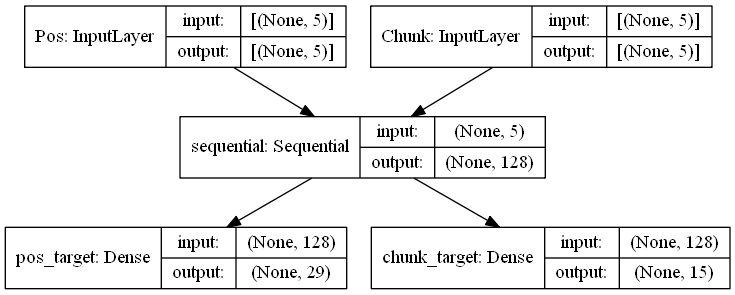

In [9]:
plot_model(model, to_file="architecture.png", show_shapes=True)

In [18]:
model.fit([X_pos_train,X_chunk_train],[Y_pos_train,Y_chunk_train],validation_data=([X_test,X_test],[Y_pos_test,Y_chunk_test]), batch_size=128,epochs=10)

Epoch 1/10
3125/3125 [==============================] - 56s 18ms/step - loss: 0.5175 - pos_target_loss: 0.2311 - chunk_target_loss: 0.2864 - pos_target_accuracy: 0.9300 - chunk_target_accuracy: 0.9055 - val_loss: 0.6907 - val_pos_target_loss: 0.3090 - val_chunk_target_loss: 0.3817 - val_pos_target_accuracy: 0.9077 - val_chunk_target_accuracy: 0.8740
Epoch 2/10
3125/3125 [==============================] - 56s 18ms/step - loss: 0.5001 - pos_target_loss: 0.2226 - chunk_target_loss: 0.2775 - pos_target_accuracy: 0.9328 - chunk_target_accuracy: 0.9087 - val_loss: 0.7061 - val_pos_target_loss: 0.3165 - val_chunk_target_loss: 0.3897 - val_pos_target_accuracy: 0.9072 - val_chunk_target_accuracy: 0.8738
Epoch 3/10
3125/3125 [==============================] - 56s 18ms/step - loss: 0.4861 - pos_target_loss: 0.2168 - chunk_target_loss: 0.2693 - pos_target_accuracy: 0.9346 - chunk_target_accuracy: 0.9120 - val_loss: 0.7168 - val_pos_target_loss: 0.3205 - val_chunk_target_loss: 0.3963 - val_pos_targ

### Commentaire

### La méthode de Multi Task learning a une bonne performance (similaire à celui des modèles préedantes)  et ce qui est important a permis de diminuer le temps d'entrainement. Au lieu d'entrainer 2 modèles séparés avec étapes communs, le modèle s'entraine qu’une seule fois ce qui réduit fortement le temps nécessaire pour obtenir le résultat pour les 2 taches.


## Hierarchical learning
Une autre façon de faire du multi-task consiste à construire une architecture en cascade où les tâches n'interviennent pas à la même profondeur du réseau de neurones.

### Consigne :
- En vous inspirant de la partie précedente, entrainer un modèle en cascade de type : 
                              POS
                            /
EMBEDDING - DENSE - DROPOUT 
                            \
                              DENSE - DROPOUT - CHUNK
                              
Autrement dit, dans cette approche, on pré-suppose que  
- EMBEDDING - DENSE - DROPOUT apprend une représentation suffisante pour prédire le POS-TAG
- plus de layer sont nécessaires pour le Shallow parsing
- la représentation intermédiaire EMBEDDING - DENSE - DROPOUT est un bon point de départ pour le shallow parsing

In [10]:
shared_nn=Sequential()
shared_nn.add(Embedding(38308,50,input_length=5,trainable=True))

shared_nn.add(Flatten())
shared_nn.add(Dense(128,input_dim=680238, activation=activations.relu))
shared_nn.add(Dropout(0.15))

In [11]:
pos_input = Input(shape=(5,), dtype='int32', name='Pos')
chunk_input =Input(shape=(5,), dtype='int32',name='Chunk')

In [12]:
pos_representation =shared_nn(pos_input)
chunk_representation =shared_nn(chunk_input)

pos_target = Dense(29,activation=activations.softmax, name='pos_target')(pos_representation)

chunk_next1 = Dense(64,activation=activations.relu, name='chunk_next1')(chunk_representation)
chunk_next2=Dropout(0.15, name='chunk_next2')(chunk_next1)
chunk_target = Dense(15,activation=activations.softmax, name='chunk_target')(chunk_next2)

In [13]:
model= Model(inputs=[pos_input,chunk_input],outputs=[pos_target,chunk_target])

In [14]:
model.compile(loss =['categorical_crossentropy','categorical_crossentropy'] ,
              optimizer = "RMSprop",
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Pos (InputLayer)                [(None, 5)]          0                                            
__________________________________________________________________________________________________
Chunk (InputLayer)              [(None, 5)]          0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          1947528     Pos[0][0]                        
                                                                 Chunk[0][0]                      
__________________________________________________________________________________________________
chunk_next1 (Dense)             (None, 64)           8256        sequential_1[1][0]         

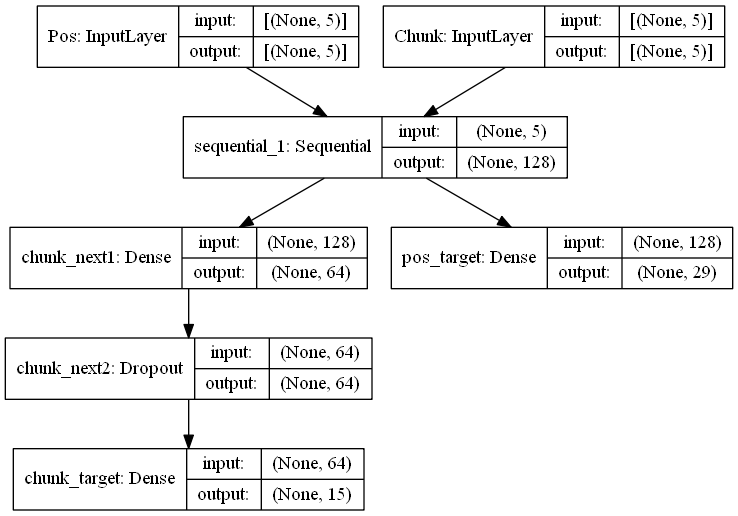

In [16]:
plot_model(model, to_file="architecture_hiearchique.png", show_shapes=True)

In [25]:
model.fit([X_pos_train,X_chunk_train],[Y_pos_train,Y_chunk_train],validation_data=([X_test,X_test],[Y_pos_test,Y_chunk_test]), batch_size=128,epochs=10)

Epoch 1/10
3125/3125 [==============================] - 61s 19ms/step - loss: 1.6880 - pos_target_loss: 0.8603 - chunk_target_loss: 0.8278 - pos_target_accuracy: 0.7748 - chunk_target_accuracy: 0.7346 - val_loss: 0.7885 - val_pos_target_loss: 0.3546 - val_chunk_target_loss: 0.4339 - val_pos_target_accuracy: 0.8931 - val_chunk_target_accuracy: 0.8556
Epoch 2/10
3125/3125 [==============================] - 59s 19ms/step - loss: 0.7341 - pos_target_loss: 0.3211 - chunk_target_loss: 0.4130 - pos_target_accuracy: 0.9034 - chunk_target_accuracy: 0.8642 - val_loss: 0.7111 - val_pos_target_loss: 0.3153 - val_chunk_target_loss: 0.3958 - val_pos_target_accuracy: 0.9046 - val_chunk_target_accuracy: 0.8683
Epoch 3/10
3125/3125 [==============================] - 57s 18ms/step - loss: 0.6343 - pos_target_loss: 0.2731 - chunk_target_loss: 0.3612 - pos_target_accuracy: 0.9167 - chunk_target_accuracy: 0.8822 - val_loss: 0.6923 - val_pos_target_loss: 0.3051 - val_chunk_target_loss: 0.3872 - val_pos_targ

### Commentaire

### Lors de l'exécution du modèle précédent on peut voir que la performance de chunk tagging tâche est moindre. L'ajout des étapes supplémentaires pour cette tache a permis d'avoir une meilleure accuracy sur cette tâche. 

### A partir de la 3eme itération l'accuracy s'améliore mais la hausse dans accuracy n'est pas élevée. Pour cette raison pour entrainement des modèles je n'ai pas pris un nombre d'itérations trop élevé.


# Question optionnelle 
- Comment feriez vous, en utilisant la classe Model, pour pouvoir extraire l'embedding tuné sur le modèle pour un mot donné? Tenter de l'implémenter.